# Cross-Correlating Supernova Light Curves

This notebook performs a cross-correlation between the light curve of SN1987A and light curves of Gaia stars crossing the SETI Ellipsoid. The Gaia DR3 light curves are far from ideal for this analysis, which is based on the idea that a potential intelligent civilization may send out a signal that mimics their observation of a supernova or other conspicuous astrophysical event, because the sampling is sparse and the light curves are generally only present for stars classified as variable, which have periodicity on a much shorter timescale than a supernova. However, it may be valuable to further explore this analysis on light curves from other surveys or telescopes.

In [1]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import ellipsoid
import lightCurve

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.gaia import Gaia
import random

from scipy import signal
from scipy.signal import correlate
from scipy.interpolate import interp1d

### Read in SN photometry data from Open Astronomy Catalog
#### API description at https://github.com/astrocatalogs/OACAPI

In [50]:
data = pd.read_csv('https://api.astrocats.space/SN1987A/photometry/time+band+magnitude?format=csv')
data = data.dropna()

In [51]:
photometry = Table.from_pandas(data)

Subtract MJD of observation date

In [52]:
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms') # SN1987A observation date
photometry['time'] = photometry['time']-t0.mjd

Select V band measurements only

In [53]:
vmask = photometry['band']=='V'

In [54]:
lc = photometry[vmask]

Plot the light curve

Text(0, 0.5, 'Magnitude')

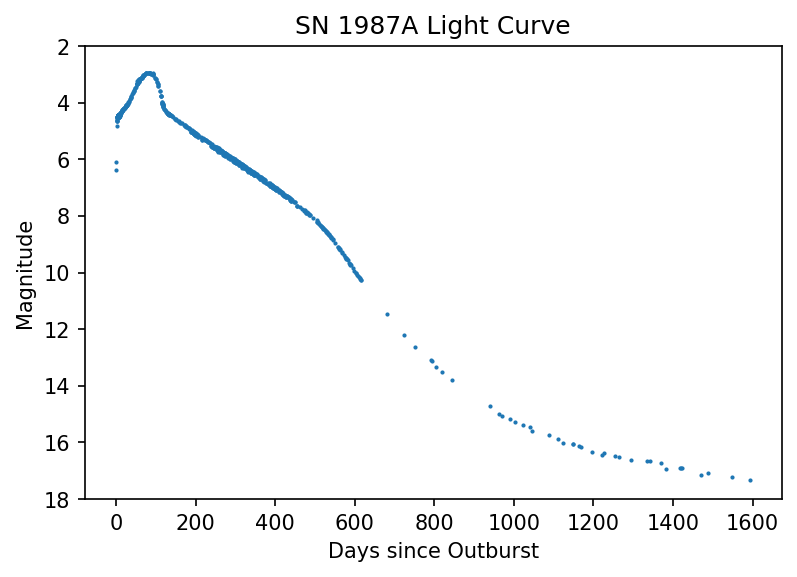

In [55]:
fig = plt.figure(figsize=[6,4], dpi=150)
plt.scatter(lc['time'], lc['magnitude'], s=1)
plt.ylim(18,2)
plt.title('SN 1987A Light Curve')
plt.xlabel('Days since Outburst')
plt.ylabel('Magnitude')

## Get a random Gaia light curve from the crossing list

In [8]:
file_name = '../Gaia_var_class'
c1, stars = ellipsoid.readFile(file_name)
tol = 0.1

In [9]:
#Properties of SN1987A
c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [10]:
c1_x, stars_x = ellipsoid.crossErrorEllipsoid(c0, t0, c1, stars, tol)
print(f'{len(stars_x)} stars have crossed the ellipsoid during Gaia DR3 data collection time')

217 stars have crossed the ellipsoid during Gaia DR3 data collection time


In [62]:
ids = stars_x['id']
lcChoice = str(random.choice(ids))

In [ ]:
from astroquery.gaia import Gaia
Gaia.login()

In [63]:
lcs = lightCurve.retrieveLC(lcChoice)
glcDict, bplcDict, rplcDict = lightCurve.lcBandDict(lcs)
# each dictionary contains the source_id as a key and the light curve in the specified band as the values

INFO: Query finished. [astroquery.utils.tap.core]


/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


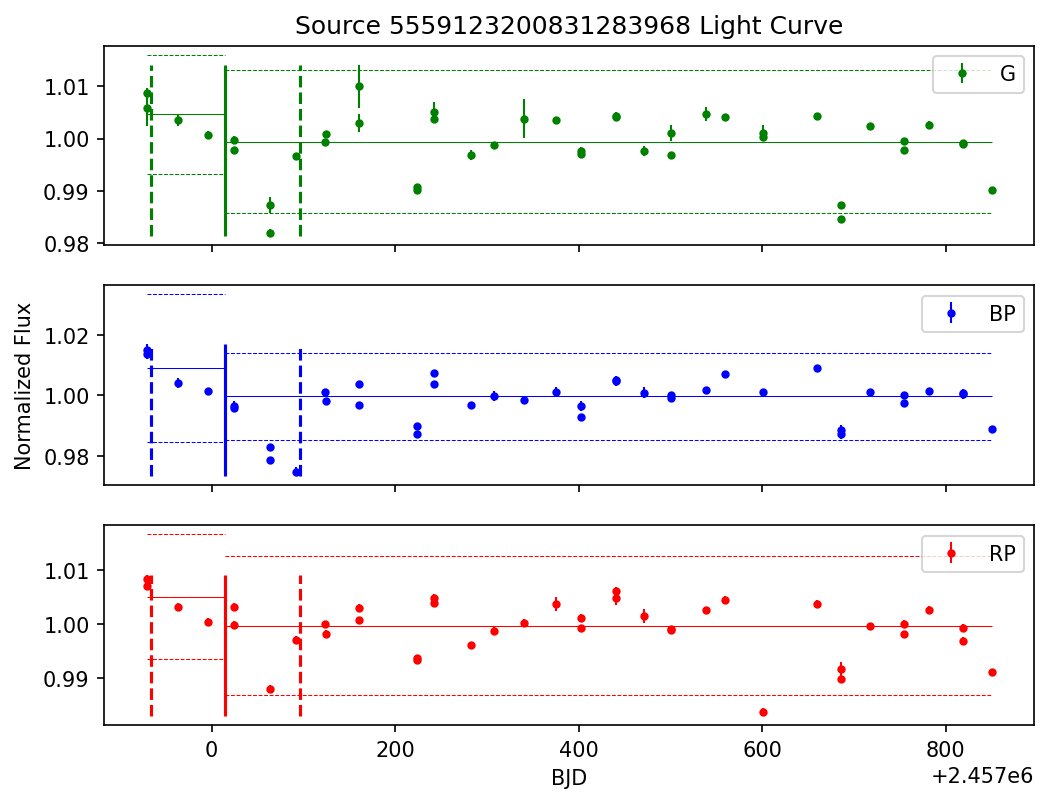

In [64]:
id_mask = stars_x['id'] == int(lcChoice)
lightCurve.plotLC(str(lcChoice), c1_x[id_mask], stars_x[id_mask], glcDict, bplcDict, rplcDict, y='flux')

## Cross-correlation

In [65]:
lcDict = glcDict # choose g, bp, or rp light curve for cross-correlation

lcTimes = Time(lcDict[lcChoice]['time'].value + 2455197.5, format='jd')
lcFlux = lcDict[lcChoice]['flux']
lcFerr = lcDict[lcChoice]['flux_error']
lcMag = lcDict[lcChoice]['mag']
# time offset described at https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_photometry/ssec_dm_epoch_photometry.html

In [66]:
# Add crossing time to supernova light curve times
xtime = ellipsoid.xTime(c1_x[id_mask])[0]
lc['time'] = lc['time'] + xtime

In [67]:
# Add "normalized flux" column
lc['flux'] = (10**(-0.4*lc['magnitude']))/np.max(10**(-0.4*lc['magnitude']))

### Top Hat Cross-correlation

The cross-correlation can be done with the raw SN light curve (as it is below), but using a top hat function instead may be advantageous because of the sparsity of Gaia data.

#### Find FWHM of SN light curve for top hat function

In [68]:
currentFlux = 0
currentIndex = 0
startBox = 0
endBox = 0
while currentFlux < 0.5:
    currentFlux = lc['flux'][currentIndex]
    currentIndex += 1
startBox = lc['time'][currentIndex]
while currentFlux > 0.5:
    currentFlux = lc['flux'][currentIndex]
    currentIndex += 1  
endBox = lc['time'][currentIndex]

# endBox - startBox is the FWHM of the SN

In [69]:
# top hat function
def box(x, start, end, height, baseline):
    box = np.piecewise(x, [x < start, x > end], [baseline, baseline, baseline+height])
    return box

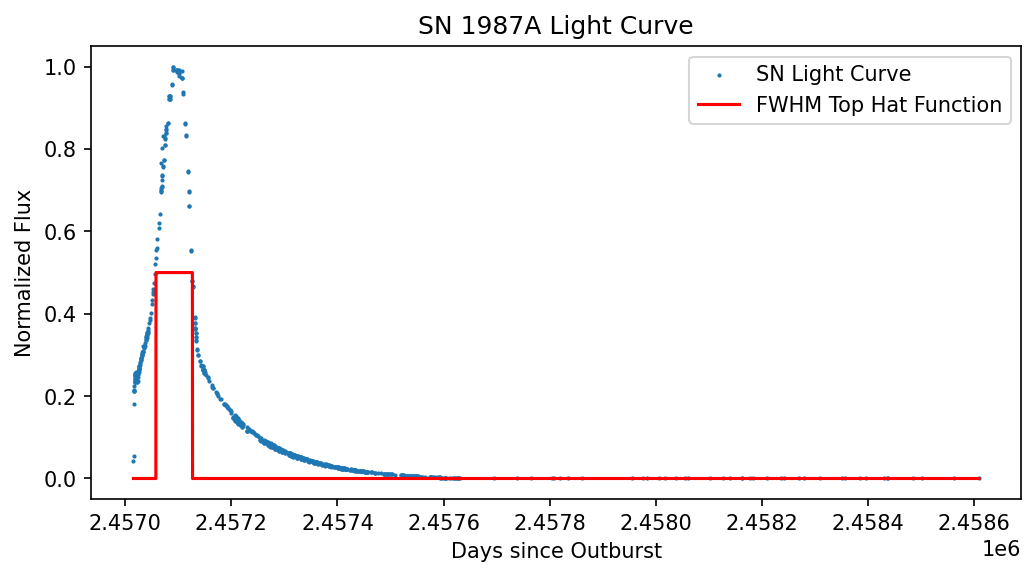

In [70]:
fig = plt.figure(figsize=[8,4], dpi=150)
plt.scatter(lc['time'], lc['flux'], s=1, label='SN Light Curve')
plt.title('SN 1987A Light Curve')
plt.xlabel('Days since Outburst')
plt.ylabel('Normalized Flux')

xs = np.linspace(lc['time'][0], lc['time'][-1], 10000)
plt.plot(xs, box(xs, startBox, endBox, 0.5, 0), c='r', label='FWHM Top Hat Function')
plt.legend()

#### Create a top hat function with baseline 1 and height up to the maximum flux value, width equal to the FWHM of the SN, and time values taken from the star light curve (so discrete cross-correlation can be performed)

In [71]:
rtimes = lcTimes.value >= xtime
fluxBox = box(lcTimes.value[rtimes], startBox, endBox, max(lcFlux.value)-1, 1)

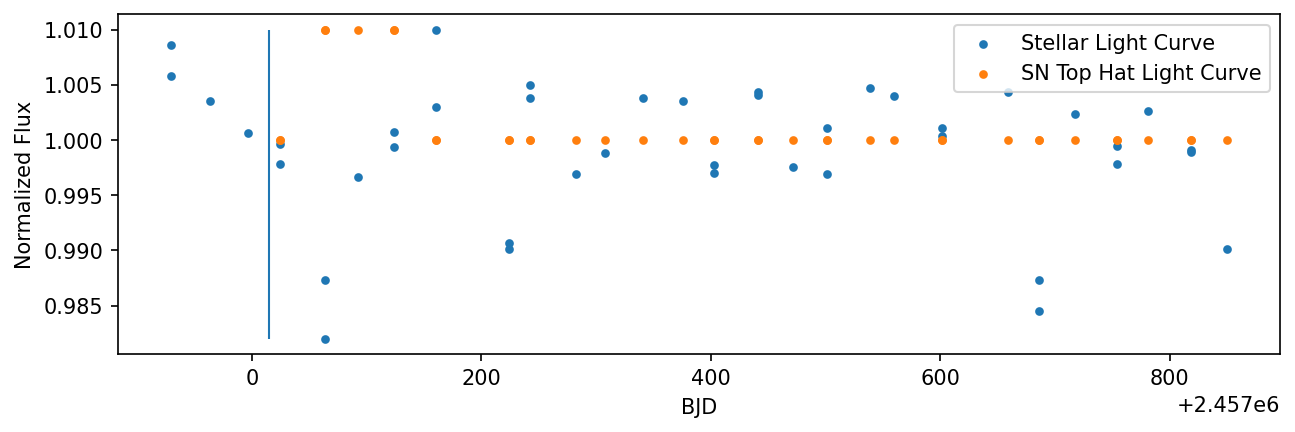

In [72]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value), lw=1)
plt.scatter(lcTimes.value, lcFlux, label = 'Stellar Light Curve', s=10)
plt.scatter(lcTimes.value[rtimes], fluxBox, label = 'SN Top Hat Light Curve', s=10)
plt.ylabel('Normalized Flux')
plt.xlabel('BJD')
plt.legend()

#### Box Cross-Correlation

In [73]:
corrLCBox = correlate(lcFlux[rtimes]-1, fluxBox-1, mode='full') # correlate residual normalized fluxes
lagsBox = signal.correlation_lags(fluxBox.size, fluxBox.size, mode="full") # lags from cross-correlation
lagBox = lagsBox[np.argmax(corrLCBox)] # lag with maximum correlation

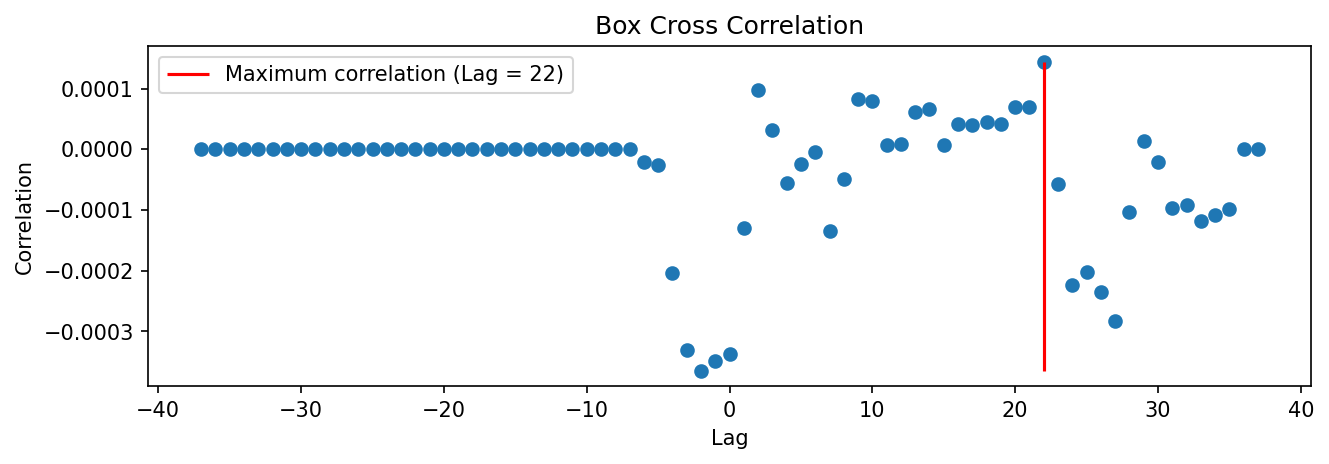

In [74]:
plt.figure(figsize=[10,3], dpi=150)

plt.scatter(lagsBox, corrLCBox)
plt.vlines(lagBox, np.min(corrLCBox), np.max(corrLCBox), color = 'r', label = f'Maximum correlation (Lag = {lagBox})')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Box Cross Correlation')
plt.legend()

What does this tell us? The two light curves are most similar if we displace the SN or star light curve by the lag value of the maximum correlation. We therefore want the peak in the above plot to be at a lag of 0, which would indicate that there is potentially a signal at the ellipsoid crossing time, because the section of the light curve at that time most closely resembles a top hat function with a FWHM of the supernova.

Below, we see the effect of shifting the SN light curve to the right by the peak lag value. The reason why this lag value has the maximum correlation becomes apparent from this plot--we are esentially picking out the few consecutive points in the star light that are maximal, and thus will have the highest correlation with a top hat function. We can also clearly see why the sparsity of the Gaia light curve data is far from ideal for this analysis, as the top hat function will only contains a few nonzero values when interpolated to the time values of the stellar light curve.

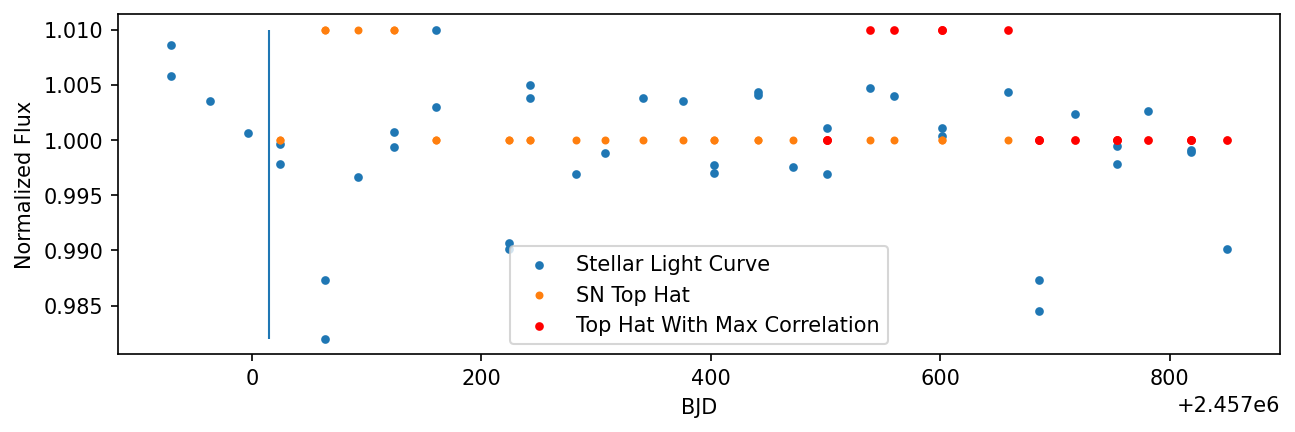

In [75]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value), lw=1)
plt.scatter(lcTimes.value, lcFlux, label = 'Stellar Light Curve', s=10)
plt.scatter(lcTimes.value[rtimes], fluxBox, label = 'SN Top Hat', s=8)
plt.scatter(lcTimes.value[rtimes][lagBox:], fluxBox[:-lagBox], label = 'Top Hat With Max Correlation', s=10, c='r')

plt.ylabel('Normalized Flux')
plt.xlabel('BJD')
plt.legend()

### Supernova Light Curve Cross-correlation

Again, with the sparsity of Gaia photometry data, there will likely be no significant difference between a top hat cross correlation and a cross correlation with the raw supernova light curve, but it still may be useful to consider both.

In [76]:
rFlux = lc['flux']/60 + 0.996 # "reduce" the normalized SN flux so it is of a similar magnitude as the stellar flux
f = interp1d(lc['time'], rFlux) # interpolate the SN light curve

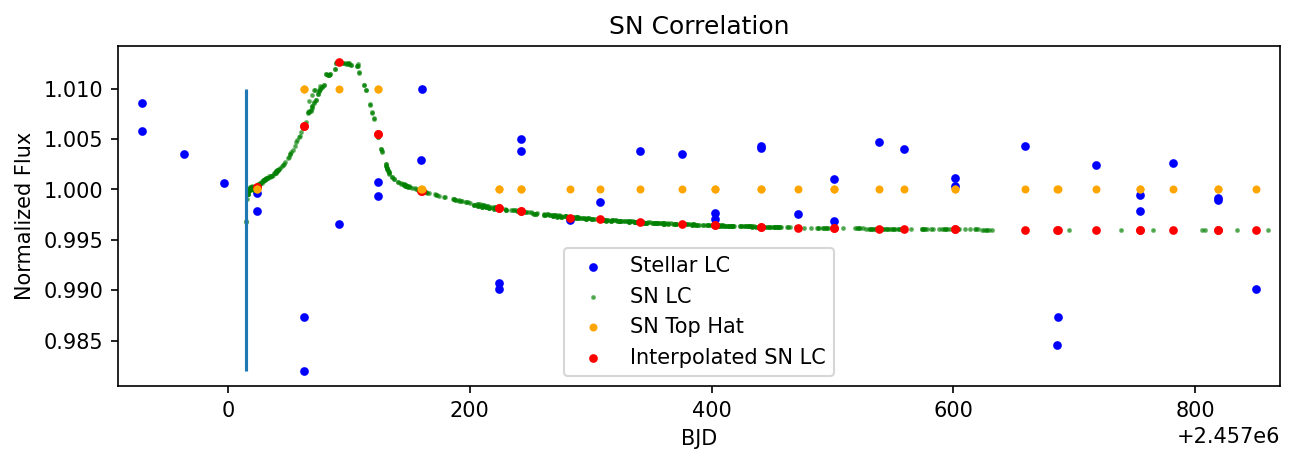

In [78]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux, label='Stellar LC', c='b', s=10)
plt.scatter(lc['time'], rFlux, label='SN LC', s=2, c='g', alpha=0.5)
plt.scatter(lcTimes.value[rtimes], fluxBox, label = 'SN Top Hat', s=8, c='orange', zorder=100)
plt.scatter(lcTimes.value[rtimes], f(lcTimes.value[rtimes]), label='Interpolated SN LC', s=10, c='r')
plt.xlim(lcTimes.value[0]-20, lcTimes.value[-1]+20)
plt.legend()

plt.xlabel('BJD')
plt.ylabel('Normalized Flux')
plt.title('SN Correlation')

plt.savefig('../Figures/SNxcorr.pdf', dpi=500, format='pdf', bbox_inches='tight')

#### SN Cross Correlation

In [79]:
corrLC= correlate(lcFlux[rtimes]-1, f(lcTimes.value[rtimes])-1, mode='full') # correlate residual normalized fluxes
lagsLC = signal.correlation_lags(lcTimes.value[rtimes].size, lcTimes.value[rtimes].size, mode="full") # lags from cross-correlation
lagLC = lagsLC[np.argmax(corrLC)] # lag with maximum correlation

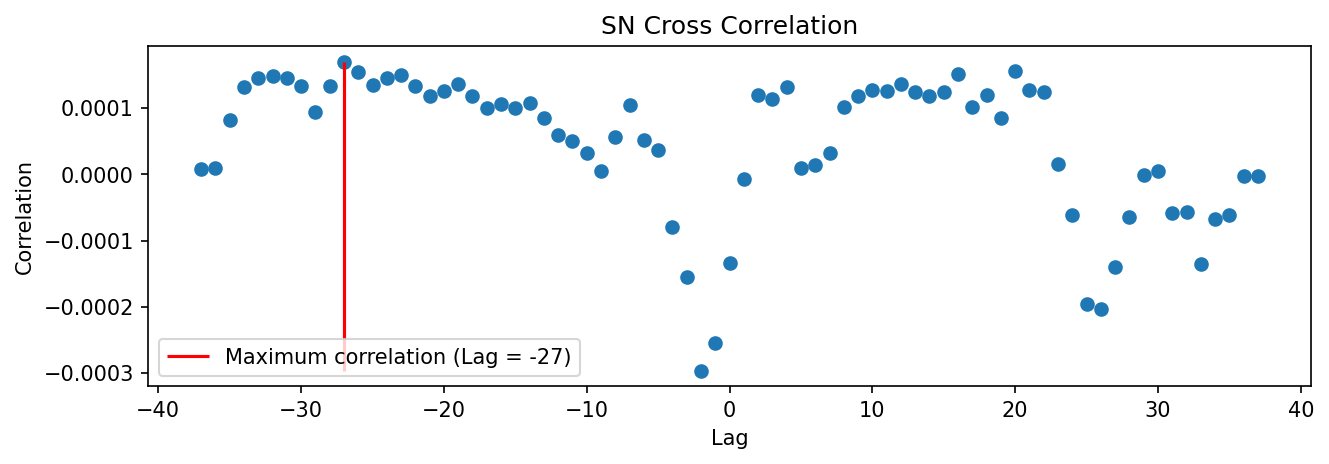

In [80]:
plt.figure(figsize=[10,3], dpi=150)

plt.scatter(lagsLC, corrLC)
plt.vlines(lagLC, np.min(corrLC), np.max(corrLC), color = 'r', label = f'Maximum correlation (Lag = {lagLC})')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('SN Cross Correlation')
plt.legend()

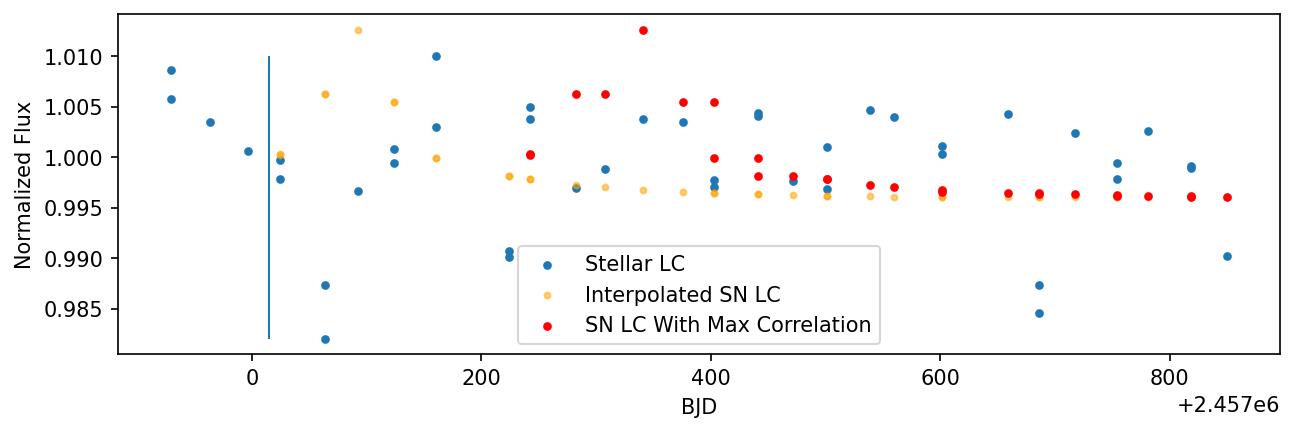

In [81]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value), lw=1)
plt.scatter(lcTimes.value, lcFlux, label = 'Stellar LC', s=10)
plt.scatter(lcTimes.value[rtimes], f(lcTimes.value[rtimes]), label='Interpolated SN LC', s=8, c='orange', alpha=0.5)
plt.scatter(lcTimes.value[rtimes][lagLC:], f(lcTimes.value[rtimes])[:-lagLC], label = 'SN LC With Max Correlation', s=10, c='red')

plt.ylabel('Normalized Flux')
plt.xlabel('BJD')
plt.legend()

The results are similar to those from the top hat function cross-correlation--uneven and sparse time sampling causes the cross-correlation to find the points in the stellar light curve where the flux is the highest, since those are most similar to the bright supernova outburst.